In [84]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd


In [85]:
input = pd.read_csv('input_train.csv')
output = pd.read_csv('output_train.csv')

rin = input.transpose()
rout = output.transpose()


In [229]:

X = np.array(rin)
y = np.array(rout)

# Split the data into training and testing sets
indices = rin.index
X_train, X_test, y_train, y_test, train_idx, test_idx = train_test_split(X, y, indices, test_size=0.1)

# Standardize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Convert the data to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

# Define the model with a hidden layer
class MultiOutputLinearRegression(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(MultiOutputLinearRegression, self).__init__()
        self.linear1 = nn.Linear(input_dim, hidden_dim)
        self.relu = nn.ReLU()
        self.linear2 = nn.Linear(hidden_dim, output_dim)
    
    def forward(self, x):
        x = self.linear1(x)
        x = self.relu(x)
        x = self.linear2(x)
        return x

# Initialize the model
input_dim = X_train.shape[1]
hidden_dim = 32  # You can experiment with different sizes for the hidden layer
output_dim = y_train.shape[1]
model = MultiOutputLinearRegression(input_dim, hidden_dim, output_dim)

# Define the loss function and optimizer with L2 regularization (weight decay)
criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, weight_decay=1e-4)  # You can experiment with different learning rates and weight decay values

# Define a learning rate scheduler
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.1)  # Adjust step_size and gamma as needed

# Train the model
num_epochs = 2000
for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    loss.backward()
    optimizer.step()
    
    # Step the scheduler
    scheduler.step()
    
    if (epoch+1) % 500 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, Learning Rate: {scheduler.get_last_lr()[0]:.6f}')

# Evaluate the model
model.eval()
with torch.no_grad():
    train_predictions = model(X_train_tensor)
    test_predictions = model(X_test_tensor)
    train_loss = criterion(train_predictions, y_train_tensor)
    test_loss = criterion(test_predictions, y_test_tensor)
    print(f'Train Loss: {train_loss.item():.4f}')
    print(f'Test Loss: {test_loss.item():.4f}')

# Calculate Mean Squared Error for training and testing sets
train_mse = mean_squared_error(y_train, train_predictions.numpy())
test_mse = mean_squared_error(y_test, test_predictions.numpy())
print(f'Train MSE: {train_mse:.4f}')
print(f'Test MSE: {test_mse:.4f}')

train_r2 = r2_score(y_train, train_predictions.numpy())
test_r2 = r2_score(y_test, test_predictions.numpy())
print(f'Train R-squared: {train_r2:.4f}')
print(f'Test R-squared: {test_r2:.4f}')

# Store the predictions in y_pred
y_pred = test_predictions.numpy()

Epoch [500/2000], Loss: 25033.9707, Learning Rate: 0.000000
Epoch [1000/2000], Loss: 25033.9727, Learning Rate: 0.000000
Epoch [1500/2000], Loss: 25033.9727, Learning Rate: 0.000000
Epoch [2000/2000], Loss: 25033.9727, Learning Rate: 0.000000
Train Loss: 25033.9727
Test Loss: 5289.4819
Train MSE: 25033.9695
Test MSE: 5289.4818
Train R-squared: 0.3957
Test R-squared: -0.4126


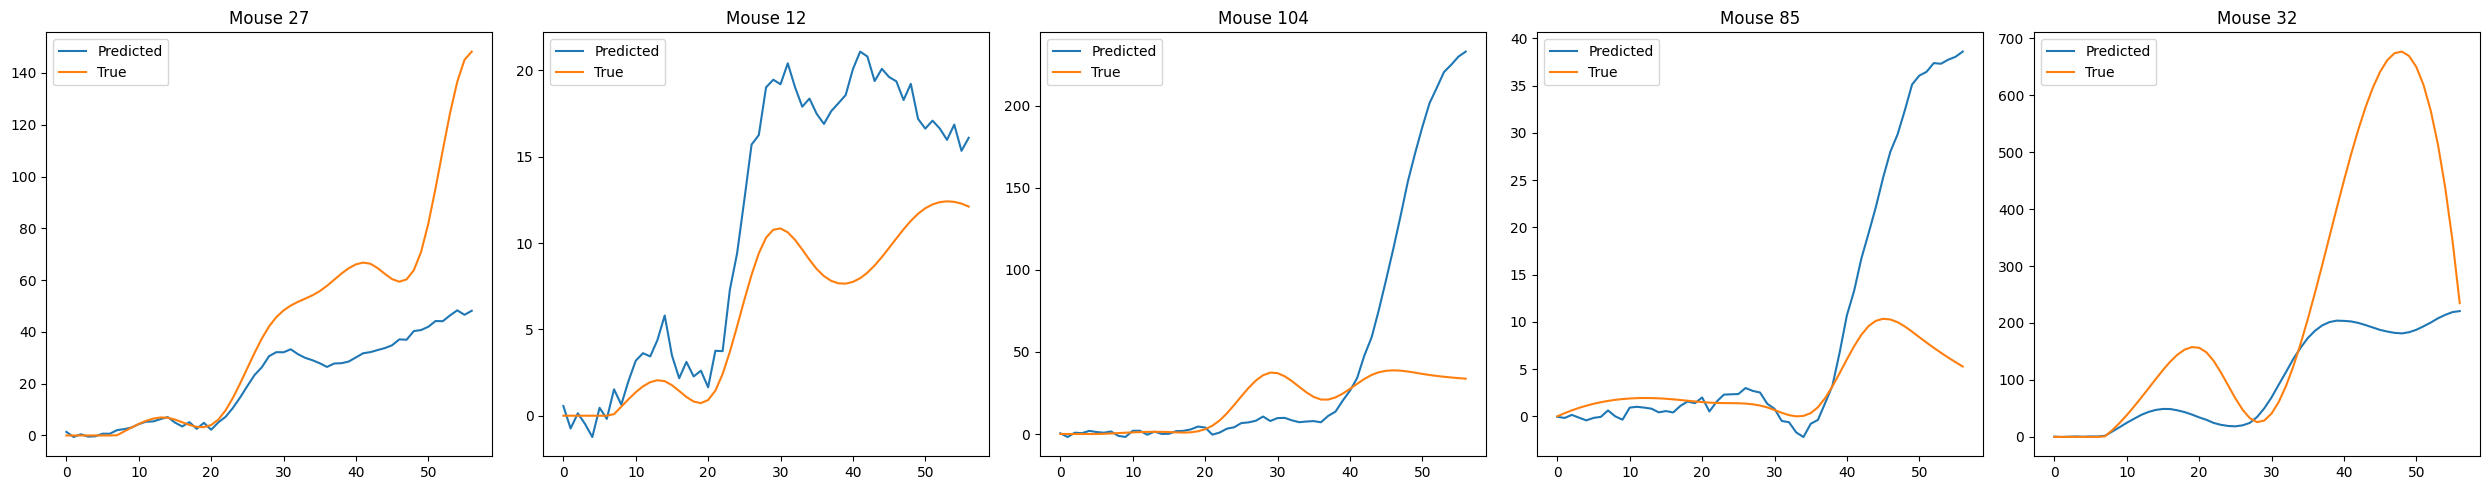

In [230]:

# Create subplots
fig, axes = plt.subplots(1, 5, figsize=(25, 5))

# Plot the first 5 predictions and the corresponding true values
for i in range(5):
    mouse_label = test_idx[i]
    axes[i].plot(y_pred[i], label='Predicted')
    axes[i].plot(y_test[i], label='True')
    axes[i].set_title(f'Mouse {mouse_label}')
    axes[i].legend()

plt.tight_layout()
plt.show()


